<small>
Copyright (c) 2017 Andrew Glassner

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
</small>



# Deep Learning From Basics to Practice
## by Andrew Glassner, https://dlbasics.com, http://glassner.com
------
## Chapter 13: Classifiers
### Notebook 2: SVMs

This notebook is provided as a “behind-the-scenes” look at code used to make some of the figures in this chapter. It is still in the hacked-together form used to develop the figures, and is only lightly commented.

In [1]:
# These figures are inspired by those in
# http://nbviewer.jupyter.org/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.07-Support-Vector-Machines.ipynb
# from the book
# Python Data Science Handbook by Jake VanderPlas

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.datasets.samples_generator import make_blobs
from sklearn.svm import SVC
import math
from mpl_toolkits import mplot3d

import seaborn as sns; sns.set()

In [3]:
# Make a File_Helper for saving and loading files.

save_files = True

import os, sys, inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
sys.path.insert(0, os.path.dirname(current_dir)) # path to parent dir
from DLBasics_Utilities import File_Helper
file_helper = File_Helper(save_files)

Using TensorFlow backend.


In [4]:
def make_blob_in_box(num_samples, random_state, xlo, xhi, ylo, yhi):
    xy, c = make_blobs(n_samples=num_samples, centers=1, random_state=random_state, cluster_std=1)
    x_min = min(xy[:,0])
    x_max = max(xy[:,0])
    y_min = min(xy[:,1])
    y_max = max(xy[:,1])
    xy = [np.array([np.interp(v[0], [x_min, x_max], [xlo, xhi]), 
                    np.interp(v[1], [y_min, y_max], [ylo, yhi])]) for v in xy]
    return np.array(xy)

In [5]:
def make_demo_blobs_distinct():
    blob_samples = 50
    v1 = make_blob_in_box(num_samples=blob_samples, random_state=42, xlo= -6, xhi= 0, ylo=1, yhi=5)
    v2 = make_blob_in_box(num_samples=blob_samples, random_state=46, xlo= 0, xhi = 6, ylo=-8, yhi=-3)
    c1 = [0]*len(v1)
    c2 = [1]*len(v2)
    allv = np.append(v1, v2, axis=0)
    allc = np.append(c1, c2, axis=0)
    return (allv, allc)

In [6]:
def make_demo_blobs_overlap():
    blob_samples = 50
    v1 = make_blob_in_box(num_samples=blob_samples, random_state=42, xlo= -2, xhi = 2, ylo = -1, yhi = 3)
    v2 = make_blob_in_box(num_samples=blob_samples, random_state=46, xlo= -1, xhi = 3, ylo= -3, yhi= 1)
    c1 = [0]*len(v1)
    c2 = [1]*len(v2)
    allv = np.append(v1, v2, axis=0)
    allc = np.append(c1, c2, axis=0)
    return (allv, allc)

In [7]:
def get_X_range(X):
    return [min(X[:, 0])*1.1, max(X[:, 0])*1.1]

In [8]:
def get_Y_range(X):
    return [min(X[:, 1])*1.1, max(X[:, 1])*1.1]

In [9]:
def draw_demo_blobs(X, y, filename):
    x_range = get_X_range(X)
    plt.xlim(x_range[0], x_range[1])
    plt.scatter(X[:, 0], X[:, 1], c=y, s=Scatter_dot_size, cmap='cool')
    plt.xticks([],[])
    plt.yticks([],[])
    file_helper.save_figure(filename)
    plt.show()

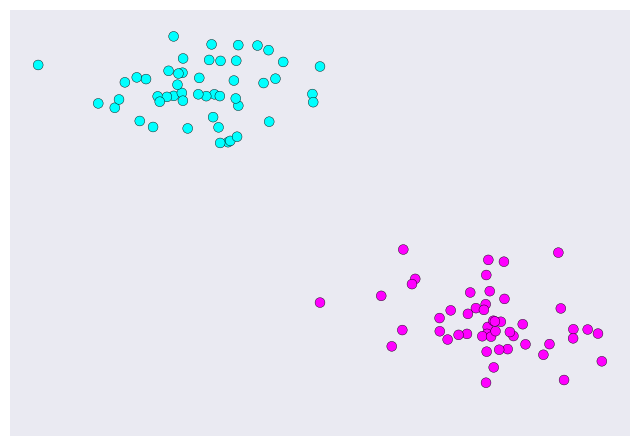

In [10]:
Scatter_dot_size = 50

X, y = make_demo_blobs_distinct()  
draw_demo_blobs(X, y, 'SVM-demo-blobs-distinct')

In [11]:
def draw_possible_lines(X, y, MB_list):
    x_range = get_X_range(X)
    x_values = np.linspace(x_range[0], x_range[1])
    plt.scatter(X[:, 0], X[:, 1], c=y, s=Scatter_dot_size, cmap='cool')
    for slope, intercept in MB_list:
        y_values = intercept+(slope*x_values)
        plt.plot(x_values, intercept+(slope*x_values), '-k')
    plt.xlim(x_range[0], x_range[1])
    plt.xticks([],[])
    plt.yticks([],[])
    file_helper.save_figure('SVM-possible-lines')
    plt.show()

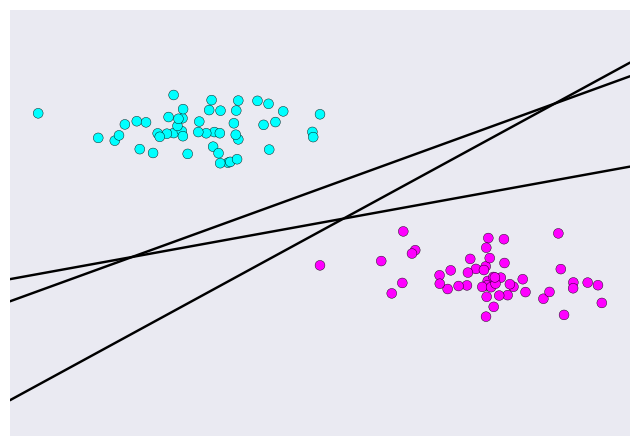

In [12]:
MB_list = [(.5, -2.5), (1, -.5), (1.5, -3)]
draw_possible_lines(X, y, MB_list)

In [13]:
def get_nearest_vertical_point(X, slope, intercept):
    yvals = [intercept+(slope*x) for x in X[:,0]]
    dvals = [abs(yvals[i] - X[i,1]) for i in range(len(X))]
    i = np.argmin(dvals)
    d = dvals[i]
    return (d, i)

In [14]:
def draw_possible_lines_with_support(X, y, MB_list):
    x_range = get_X_range(X)
    y_range = get_Y_range(X)
    x_values = np.linspace(x_range[0], x_range[1])
    plt.figure(figsize=(12,2.5))
    for i in range(len(MB_list)):
        plt.subplot(1, 3, i+1)
        (slope, intercept) = MB_list[i]
        y_values = intercept+(slope*x_values)
        (d, i) = get_nearest_vertical_point(X, slope, intercept)
        plt.scatter([X[i,0]], [X[i,1]], facecolors='none', s=Scatter_dot_size*6, edgecolors='black', 
                    linewidth=2, zorder=50)
        plt.scatter(X[:, 0], X[:, 1], c=y, s=Scatter_dot_size, cmap='cool')
        plt.plot(x_values, intercept+(slope*x_values), '-k')
        plt.fill_between(x_values, y_values-d, y_values+d, edgecolor='none', color='#aaaaaa', alpha=0.4)
        plt.xlim(x_range[0], x_range[1])
        plt.ylim(y_range[0], y_range[1])
        plt.xticks([],[])
        plt.yticks([],[])
        file_helper.save_figure('SVM-possible-lines-with-support')
    plt.show()

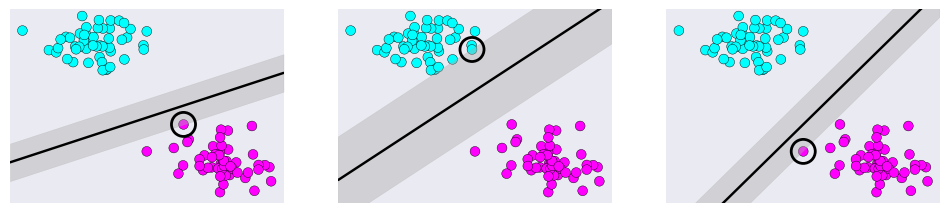

In [15]:
draw_possible_lines_with_support(X, y, MB_list)

In [16]:
def plot_boundary_and_support(X, y, model, support_vectors_alpha, C):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=Scatter_dot_size, cmap='cool')
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    x_grid = np.linspace(xlim[0], xlim[1], 30)
    y_grid = np.linspace(ylim[0], ylim[1], 30)
    Y_grid, X_grid = np.meshgrid(y_grid, x_grid)
    xy_grid = np.vstack([X_grid.ravel(), Y_grid.ravel()]).T
    P = model.decision_function(xy_grid).reshape(X_grid.shape)

    # plot decision boundary and margins
    ax.contour(X_grid, Y_grid, P, colors='k',
               levels=[-1, 0, 1], alpha=1.0,
               linestyles=['--', '-', '--'])

    sv = model.support_vectors_
    plt.scatter(sv[:,0], sv[:,1], s=Scatter_dot_size*6,  
                    facecolors='none', linewidth=2, zorder=50, 
                    alpha=support_vectors_alpha, cmap='cool')

    x_range = get_X_range(X)
    plt.xlim(x_range[0], x_range[1])
    C_string = 'C ={0:.2f}'.format(C)
    if (C > .01): 
        C_string = 'C = {0:.0e}'.format(C)
    plt.title(C_string)
    plt.xticks([],[])
    plt.yticks([],[])
    file_helper.save_figure('SVM-C-'+str(C)+'-with-support')
    plt.show()

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


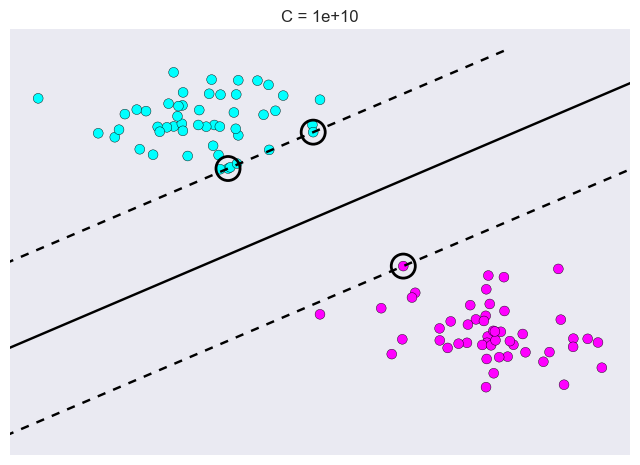

In [17]:
C=1E10
model = SVC(kernel='linear', C=C)
model.fit(X, y)
plot_boundary_and_support(X, y, model, 1.0, C)

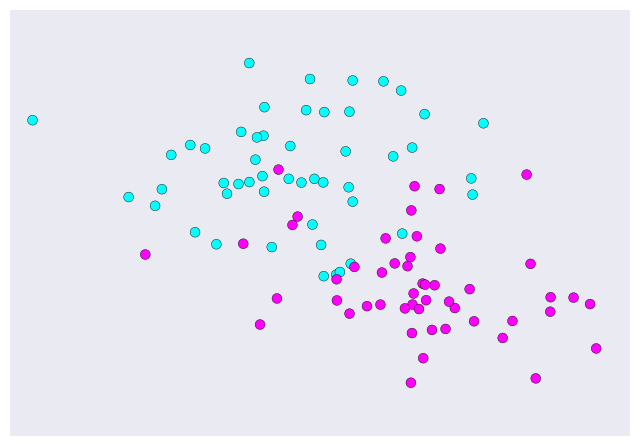

In [18]:
X_overlap, y_overlap = make_demo_blobs_overlap()  
draw_demo_blobs(X_overlap, y_overlap, 'SVM-demo-blobs-overlap')

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


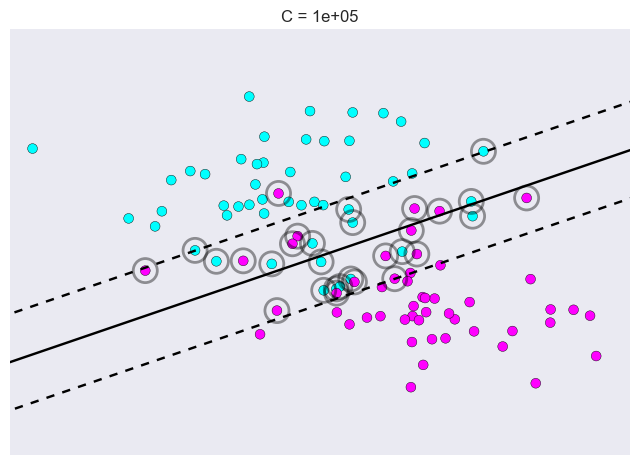

In [19]:
C = 1E5
model = SVC(kernel='linear', C=C)
model.fit(X_overlap, y_overlap)
plot_boundary_and_support(X_overlap, y_overlap, model, 0.4, C)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


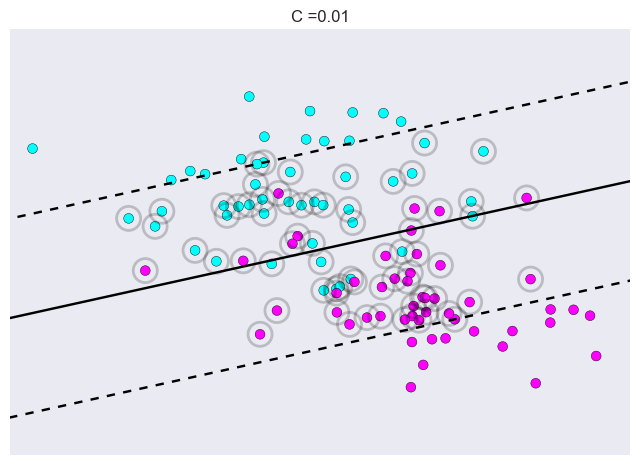

In [20]:
C=0.01
model = SVC(kernel='linear', C=C)
model.fit(X_overlap, y_overlap)
plot_boundary_and_support(X_overlap, y_overlap, model, 0.2, C)

In [21]:
def show_rings_pair(X, y):
    plt.figure(figsize=(6,6))
    lim_lo = np.min(X)
    lim_hi = np.max(X)
    plt.xlim(lim_lo*1.1, lim_hi*1.1)
    plt.ylim(lim_lo*1.1, lim_hi*1.1)
    plt.scatter(X[:,0], X[:,1], c=y, s=Scatter_dot_size, cmap='cool')
    plt.xticks([],[])
    plt.yticks([],[])
    file_helper.save_figure('SVM-ring-pair')
    plt.show()

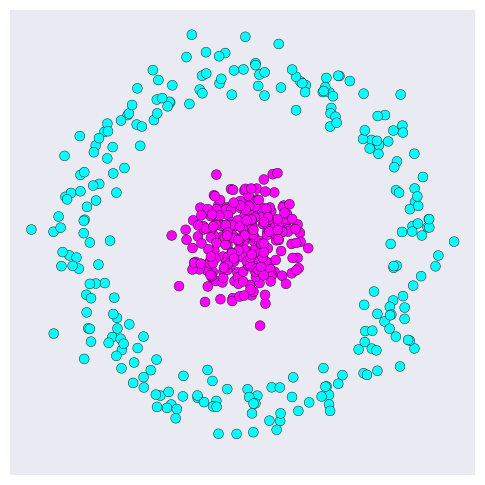

In [22]:
from sklearn.datasets import make_circles
X_rings, y_rings = make_circles(n_samples=500, factor=.2, noise=0.1)
show_rings_pair(X_rings, y_rings)

In [23]:
def augment_with_z(X):
    xyz = []
    for xy in X:
        r = math.sqrt((xy[0]*xy[0])+(xy[1]*xy[1]))
        z = r*r
        p = [xy[0], xy[1], z]
        xyz.append(p)
    return np.array(xyz)

In [24]:
def show_3D_data(X, y):
    plane_z = 0.35
    plt.figure(figsize=(12,5))
    ax = plt.subplot(1, 2, 1, projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], X[:, 2], c=y, s=50, cmap='cool')
    ps = 2
    xx, yy = np.meshgrid(np.arange(-ps, ps), np.arange(-ps, ps))
    ax.plot_surface(xx, yy, plane_z, color='#ffff00')
    ax.view_init(0, 20)
    plt.xlim(-ps, ps)
    plt.ylim(-ps, ps)
    plt.xticks([],[])
    plt.yticks([],[])
    
    ax = plt.subplot(1, 2, 2, projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], X[:, 2], c=y, s=50, cmap='cool')
    xx, yy = np.meshgrid(np.arange(-ps, ps), np.arange(-ps, ps))
    ax.plot_surface(xx, yy, plane_z, color='#ffff00')
    ax.view_init(5, 20)
    plt.xlim(-ps, ps)
    plt.ylim(-ps, ps)
    plt.xticks([],[])
    plt.yticks([],[])
    
    file_helper.save_figure('SVM-3D-rings')
    plt.show()

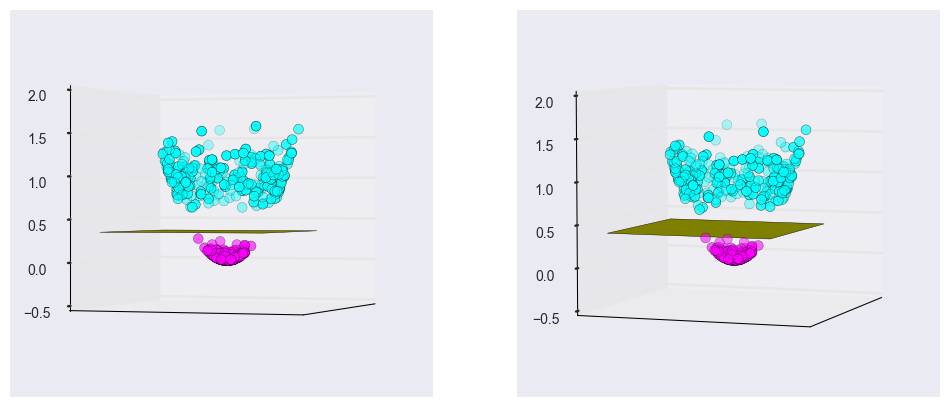

In [25]:
Xz = augment_with_z(X_rings)
show_3D_data(Xz, y_rings)

In [26]:
def show_3D_data_with_supports(X, y, model):
    plane_z = 0.35
    plt.figure(figsize=(6, 6))
    ax = plt.subplot(1, 1, 1, projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], X[:, 2], c=y, s=50, cmap='cool')
    ps = 2
    xx, yy = np.meshgrid(np.arange(-ps, ps), np.arange(-ps, ps))
    ax.plot_surface(xx, yy, plane_z, color='#ffff00')
    ax.view_init(0, 20)
    plt.xlim(-ps, ps)
    plt.ylim(-ps, ps)
    plt.xticks([],[])
    plt.yticks([],[])
    
    ax.scatter3D(Xz[model_rbf.support_][:,0], 
             Xz[model_rbf.support_][:,1],  
             Xz[model_rbf.support_][:,2], s=300, cmap='cool')
    
    file_helper.save_figure('SVM-3Drings-with-supports')
    plt.show()

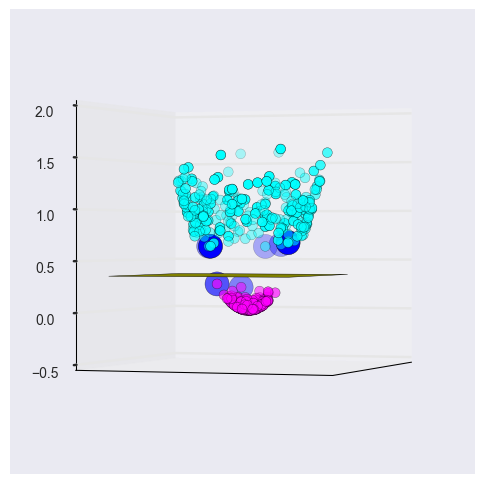

In [27]:
model_rbf = SVC(kernel='rbf', C=1E6)
model_rbf.fit(X_rings, y_rings)

show_3D_data_with_supports(Xz, y_rings, model_rbf)

In [28]:
def show_2D_data_with_supports(X_rings, y_rings, model_rbf):
    plt.figure(figsize=(6,6))
    plt.scatter(X_rings[:, 0], X_rings[:, 1], c=y_rings, s=Scatter_dot_size, cmap='cool')
    plt.scatter(model_rbf.support_vectors_[:, 0], model_rbf.support_vectors_[:, 1],
                s=6*Scatter_dot_size, lw=3, facecolors='none')
    plt.xticks([],[])
    plt.yticks([],[])
    file_helper.save_figure('SVM-2Drings-with-supports')
    plt.show()

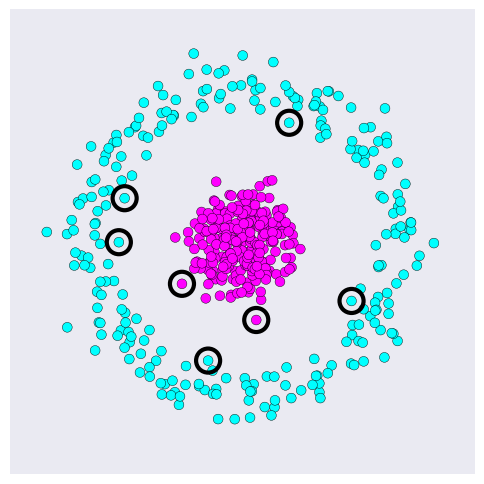

In [29]:
show_2D_data_with_supports(X_rings, y_rings, model_rbf)

In [30]:
def show_rings_and_all_SVM_stuff(X_rings, y_rings, model_rbf):
    plt.figure(figsize=(6,6))
    plt.scatter(X_rings[:, 0], X_rings[:, 1], c=y_rings, s=Scatter_dot_size, cmap='cool')
    #plot_svc_decision_function(clf)
    plt.scatter(model_rbf.support_vectors_[:, 0], model_rbf.support_vectors_[:, 1],
                s=6*Scatter_dot_size, lw=3, facecolors='none')

    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    x_grid = np.linspace(xlim[0], xlim[1], 30)
    y_grid = np.linspace(ylim[0], ylim[1], 30)
    Y_grid, X_grid = np.meshgrid(y_grid, x_grid)
    xy_grid = np.vstack([X_grid.ravel(), Y_grid.ravel()]).T
    P = model_rbf.decision_function(xy_grid)
    P = P.reshape(X_grid.shape)

    # plot decision boundary and margins
    ax.contour(X_grid, Y_grid, P, colors='k',
               levels=[-1, 0, 1], alpha=1.0,
               linestyles=['--', '-', '--'])
    plt.xticks([],[])
    plt.yticks([],[])
    file_helper.save_figure('SVM-rings-and-all-svm')
    plt.show()

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


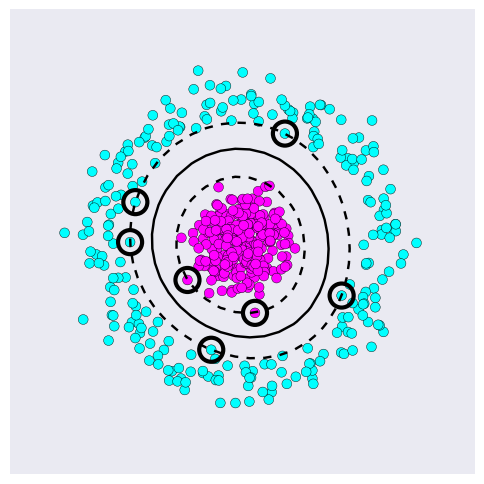

In [31]:
show_rings_and_all_SVM_stuff(X_rings, y_rings, model_rbf)